# Localization Module

In [1]:
push!(LOAD_PATH, "../src");
push!(LOAD_PATH, ENV["probcomp"]*"/Gen-Distribution-Zoo/src");

In [153]:
#nbx --fname="src/Localization.jl" --jl_module=Localization

using BenchmarkTools;
using Colors, Plots, Images;
col = palette(:default);
(cgrad::PlotUtils.ContinuousColorGradient)(xs::Vector{Vector{Float64}}) = [cgrad[x] for x in xs];
(cgrad::PlotUtils.ContinuousColorGradient)(m::Matrix{Float64}) = reshape(cgrad[m[:]], size(m));

using Fmt: @f_str, format # Python-style f-strings
using StatsBase: mean
using Random: shuffle, randperm

using Gen
using GenDistributionZoo: ProductDistribution, diagnormal
using MyUtils
using CUDA
using MyCudaUtils
using Geometry: Segment, bounding_box, segments

include("../src/pose.jl");
include("../src/cuda_raycaster_line_map_b.jl");
include("../v2/src/sensor_distribution.jl");


In [154]:
include("src/data_helper.jl");

fname = "../data/task_inputs/test_env_1.json"
_segs, _boxes, _paths = load_env(fname)
_bb = bounding_box(_segs);
_ps, _us = unpack_path(_paths[1]);

In [155]:
function lims(_segs, d=1.0)
    _bb = bounding_box(_segs);
    return Dict(
        :xlims => (_bb[1][1]-d, _bb[2][1]+d), 
        :ylims => (_bb[1][2]-d, _bb[2][2]+d)
    )
end

lims (generic function with 2 methods)

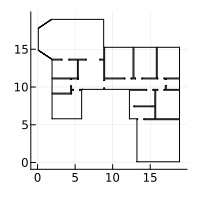

In [156]:
plot(size=(200,200), aspect_ratio=:equal; lims(_segs)...)
plot!(_segs, c=:black)

In [157]:
mvuniform = ProductDistribution(uniform);

In [133]:
#nbx
@gen function sensor_model(p, segs, as, fov, w, sig, outlier, zmax, scale_noise=false, noise_anchor=1.0)
    
    segs_ = DeviceArray(stack(Vector.(segs)))
    p_    = DeviceArray(Vector(p))
    ps_   = reshape(p_, 1, 3)

    zs_ = cast(ps_, segs_; fov=fov, num_a=length(as), zmax=zmax)
    as_ = DeviceArray(as)

    ỹ_, d̃_ = get_1d_mixture_components(zs_, as_, w; 
                wrap=false, fill=true, fill_val_z=zmax, fill_val_a=0.0);

    ỹ_ = ỹ_[1,:,:]
    d̃_ = d̃_[1,:,:]

    z ~ depthdist_2dp3(ỹ_, d̃_, sig, outlier, zmax, scale_noise, noise_anchor)

    return z
end;

In [166]:
p = _ps[1]

_fov   = 2π
_num_a = 300
_as    = create_angles(_fov, _num_a)

w       = 20
sig     = 0.1
outlier = 0.1
zmax    = 80.0

scale_noise  = true
noise_anchor = 3.0

segs = _segs
as = _as

segs_ = DeviceArray(stack(Vector.(segs)))
p_    = DeviceArray(Vector(p))
ps_   = reshape(p_, 1, 3)

zs_ = cast(ps_, segs_; fov=fov, num_a=length(as), zmax=zmax)
as_ = DeviceArray(as)


ỹ_, d̃_ = get_1d_mixture_components(zs_, as_, w; 
            wrap=false, fill=false, fill_val_z=zmax, fill_val_a=0.0);

any(ỹ_  .< 0),
any(zs_ .< 0)

(false, false)

In [167]:
p = _ps[1]

_fov   = 2π
_num_a = 100
_as    = create_angles(_fov, _num_a)

w       = 20
sig     = 0.1
outlier = 0.1
zmax    = 80.0

scale_noise  = true
noise_anchor = 3.0


z = sensor_model(p, _segs, _as, _fov, w, sig, outlier, zmax, scale_noise, noise_anchor)
y = polar_inv(z, _as)

# ----------------------
plot(size=(400,400), aspect_ratio=:equal; lims(_segs, 2)...)
plot!(_segs, c=:black)
plot!(p, c=:red, linewidth=2)
scatter!(y .* p, c=col[1], label="Obs")

80.0


DomainError: DomainError with -2.666666666666667:
Normal: the condition σ >= zero(σ) is not satisfied.

In [125]:
tr = simulate(sensor_model, (p, _segs, _as, _fov, w, sig, outlier, zmax, scale_noise, noise_anchor))

GPUCompiler.KernelError: GPU compilation of kernel #broadcast_kernel#28(CUDA.CuKernelContext, CuDeviceArray{Float64, 3, 1}, Base.Broadcast.Broadcasted{CUDA.CuArrayStyle{3}, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}, Base.OneTo{Int64}}, typeof(/), Tuple{Base.Broadcast.Broadcasted{CUDA.CuArrayStyle{3}, Nothing, typeof(Base.literal_pow), Tuple{CUDA.CuRefValue{typeof(^)}, Base.Broadcast.Broadcasted{CUDA.CuArrayStyle{3}, Nothing, typeof(-), Tuple{Base.Broadcast.Extruded{Array{Float64, 3}, Tuple{Bool, Bool, Bool}, Tuple{Int64, Int64, Int64}}, Base.Broadcast.Extruded{CuDeviceArray{Float64, 3, 1}, Tuple{Bool, Bool, Bool}, Tuple{Int64, Int64, Int64}}}}, CUDA.CuRefValue{Val{2}}}}, Base.Broadcast.Broadcasted{CUDA.CuArrayStyle{3}, Nothing, typeof(Base.literal_pow), Tuple{CUDA.CuRefValue{typeof(^)}, Base.Broadcast.Extruded{CuDeviceArray{Float64, 3, 1}, Tuple{Bool, Bool, Bool}, Tuple{Int64, Int64, Int64}}, CUDA.CuRefValue{Val{2}}}}}}, Int64) failed
KernelError: passing and using non-bitstype argument

Argument 4 to your kernel function is of type Base.Broadcast.Broadcasted{CUDA.CuArrayStyle{3}, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}, Base.OneTo{Int64}}, typeof(/), Tuple{Base.Broadcast.Broadcasted{CUDA.CuArrayStyle{3}, Nothing, typeof(Base.literal_pow), Tuple{CUDA.CuRefValue{typeof(^)}, Base.Broadcast.Broadcasted{CUDA.CuArrayStyle{3}, Nothing, typeof(-), Tuple{Base.Broadcast.Extruded{Array{Float64, 3}, Tuple{Bool, Bool, Bool}, Tuple{Int64, Int64, Int64}}, Base.Broadcast.Extruded{CuDeviceArray{Float64, 3, 1}, Tuple{Bool, Bool, Bool}, Tuple{Int64, Int64, Int64}}}}, CUDA.CuRefValue{Val{2}}}}, Base.Broadcast.Broadcasted{CUDA.CuArrayStyle{3}, Nothing, typeof(Base.literal_pow), Tuple{CUDA.CuRefValue{typeof(^)}, Base.Broadcast.Extruded{CuDeviceArray{Float64, 3, 1}, Tuple{Bool, Bool, Bool}, Tuple{Int64, Int64, Int64}}, CUDA.CuRefValue{Val{2}}}}}}, which is not isbits:
  .args is of type Tuple{Base.Broadcast.Broadcasted{CUDA.CuArrayStyle{3}, Nothing, typeof(Base.literal_pow), Tuple{CUDA.CuRefValue{typeof(^)}, Base.Broadcast.Broadcasted{CUDA.CuArrayStyle{3}, Nothing, typeof(-), Tuple{Base.Broadcast.Extruded{Array{Float64, 3}, Tuple{Bool, Bool, Bool}, Tuple{Int64, Int64, Int64}}, Base.Broadcast.Extruded{CuDeviceArray{Float64, 3, 1}, Tuple{Bool, Bool, Bool}, Tuple{Int64, Int64, Int64}}}}, CUDA.CuRefValue{Val{2}}}}, Base.Broadcast.Broadcasted{CUDA.CuArrayStyle{3}, Nothing, typeof(Base.literal_pow), Tuple{CUDA.CuRefValue{typeof(^)}, Base.Broadcast.Extruded{CuDeviceArray{Float64, 3, 1}, Tuple{Bool, Bool, Bool}, Tuple{Int64, Int64, Int64}}, CUDA.CuRefValue{Val{2}}}}} which is not isbits.
    .1 is of type Base.Broadcast.Broadcasted{CUDA.CuArrayStyle{3}, Nothing, typeof(Base.literal_pow), Tuple{CUDA.CuRefValue{typeof(^)}, Base.Broadcast.Broadcasted{CUDA.CuArrayStyle{3}, Nothing, typeof(-), Tuple{Base.Broadcast.Extruded{Array{Float64, 3}, Tuple{Bool, Bool, Bool}, Tuple{Int64, Int64, Int64}}, Base.Broadcast.Extruded{CuDeviceArray{Float64, 3, 1}, Tuple{Bool, Bool, Bool}, Tuple{Int64, Int64, Int64}}}}, CUDA.CuRefValue{Val{2}}}} which is not isbits.
      .args is of type Tuple{CUDA.CuRefValue{typeof(^)}, Base.Broadcast.Broadcasted{CUDA.CuArrayStyle{3}, Nothing, typeof(-), Tuple{Base.Broadcast.Extruded{Array{Float64, 3}, Tuple{Bool, Bool, Bool}, Tuple{Int64, Int64, Int64}}, Base.Broadcast.Extruded{CuDeviceArray{Float64, 3, 1}, Tuple{Bool, Bool, Bool}, Tuple{Int64, Int64, Int64}}}}, CUDA.CuRefValue{Val{2}}} which is not isbits.
        .2 is of type Base.Broadcast.Broadcasted{CUDA.CuArrayStyle{3}, Nothing, typeof(-), Tuple{Base.Broadcast.Extruded{Array{Float64, 3}, Tuple{Bool, Bool, Bool}, Tuple{Int64, Int64, Int64}}, Base.Broadcast.Extruded{CuDeviceArray{Float64, 3, 1}, Tuple{Bool, Bool, Bool}, Tuple{Int64, Int64, Int64}}}} which is not isbits.
          .args is of type Tuple{Base.Broadcast.Extruded{Array{Float64, 3}, Tuple{Bool, Bool, Bool}, Tuple{Int64, Int64, Int64}}, Base.Broadcast.Extruded{CuDeviceArray{Float64, 3, 1}, Tuple{Bool, Bool, Bool}, Tuple{Int64, Int64, Int64}}} which is not isbits.
            .1 is of type Base.Broadcast.Extruded{Array{Float64, 3}, Tuple{Bool, Bool, Bool}, Tuple{Int64, Int64, Int64}} which is not isbits.
              .x is of type Array{Float64, 3} which is not isbits.

